# Домашнее задание "Варианционные автоэнкодеры"

В этом домашнем задании вам предстоит реализовать несколько версий автоэнкодера для работы с изображениями.

Вы научитесь добавлять улыбку на фотографии людей, изменяя их исходное выражение лица с помощью обученной модели. А также, обучите ваш автоэнкодер генерировать изображения рукописных цифр.

# Часть 1. Vanilla Autoencoder (10 баллов)

## 1.1. Подготовка данных (1 балл)


Перед тем, как начинать работу с моделями нужно подготовить данные.

In [1]:
import numpy as np
from torch.autograd import Variable
from torchvision import datasets
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data_utils
import torch
import matplotlib.pyplot as plt

import os
import pandas as pd
import skimage.io
from skimage.transform import resize

import imageio
from PIL import Image
import kagglehub

%matplotlib inline

В этом задании вам предстоить работать с датасетом [LFW (Labeled Faces in the Wild)](https://datasets.activeloop.ai/docs/ml/datasets/lfw-dataset/#:~:text=What%20is%20LFW%20Dataset%3F,commercial%20algorithms%20prior%20to%20release).

In [ ]:
# Скачиваем картинки
images_path = kagglehub.dataset_download("jessicali9530/lfw-dataset")
print("Path to dataset files:", images_path)

Path to dataset files: /kaggle/input/lfw-dataset


In [ ]:
# Скачиваем атрибуты
attrs_path = kagglehub.dataset_download("averkij/lfw-attributes")
print("Path to dataset files:", attrs_path)

Path to dataset files: /kaggle/input/lfw-attributes


In [ ]:
DATASET_PATH ="/kaggle/input/lfw-dataset/lfw-deepfunneled/lfw-deepfunneled/"
ATTRIBUTES_PATH = "/kaggle/input/lfw-attributes/lfw_attributes.txt"

In [ ]:
def fetch_dataset(dx=80, dy=80, dimx=45, dimy=45):

    df_attrs = pd.read_csv(ATTRIBUTES_PATH, sep='\t', skiprows=1,)
    df_attrs = pd.DataFrame(df_attrs.iloc[:, :-1].values, columns = df_attrs.columns[1:])

    photo_ids = []
    for dirpath, dirnames, filenames in os.walk(DATASET_PATH):
        for fname in filenames:
            if fname.endswith(".jpg"):
                fpath = os.path.join(dirpath, fname)
                photo_id = fname[:-4].replace('_', ' ').split()
                person_id = ' '.join(photo_id[:-1])
                photo_number = int(photo_id[-1])
                photo_ids.append({'person': person_id,'imagenum': photo_number, 'photo_path': fpath})

    photo_ids = pd.DataFrame(photo_ids)
    df = pd.merge(df_attrs,photo_ids,on=('person', 'imagenum'))

    assert len(df) == len(df_attrs), "Потеряны данные при объединении датафреймов!"

    images = df['photo_path'].apply(imageio.imread)\
                                .apply(lambda img:img[dy:-dy, dx:-dx])\
                                .apply(lambda img: np.array(Image.fromarray(img).resize([dimx, dimy])) )

    images = np.stack(images.values).astype('uint8')
    attrs = df.drop(["photo_path","person","imagenum"],axis=1)

    return images, attrs

In [ ]:
# Обратите внимание, что датасет представляет собой не только картинки, но и атрибуты
# Атрибуты понадобятся в конце этого задания

images, attrs = fetch_dataset()

KeyboardInterrupt: 

In [ ]:
attrs.columns

Index(['Male', 'Asian', 'White', 'Black', 'Baby', 'Child', 'Youth',
       'Middle Aged', 'Senior', 'Black Hair', 'Blond Hair', 'Brown Hair',
       'Bald', 'No Eyewear', 'Eyeglasses', 'Sunglasses', 'Mustache', 'Smiling',
       'Frowning', 'Chubby', 'Blurry', 'Harsh Lighting', 'Flash',
       'Soft Lighting', 'Outdoor', 'Curly Hair', 'Wavy Hair', 'Straight Hair',
       'Receding Hairline', 'Bangs', 'Sideburns', 'Fully Visible Forehead',
       'Partially Visible Forehead', 'Obstructed Forehead', 'Bushy Eyebrows',
       'Arched Eyebrows', 'Narrow Eyes', 'Eyes Open', 'Big Nose',
       'Pointy Nose', 'Big Lips', 'Mouth Closed', 'Mouth Slightly Open',
       'Mouth Wide Open', 'Teeth Not Visible', 'No Beard', 'Goatee',
       'Round Jaw', 'Double Chin', 'Wearing Hat', 'Oval Face', 'Square Face',
       'Round Face', 'Color Photo', 'Posed Photo', 'Attractive Man',
       'Attractive Woman', 'Indian', 'Gray Hair', 'Bags Under Eyes',
       'Heavy Makeup', 'Rosy Cheeks', 'Shiny Skin', 'Pa

In [ ]:
attrs.shape

(13143, 73)

In [ ]:
len(images)

13143


Разбейте датасет изображений и атрибутов на train и val, выведите несколько картинок в output, чтобы посмотреть, как они выглядят, и приведите картинки к тензорам pytorch, чтобы можно было скормить их сети:

In [2]:
from torchvision import transforms

transform = transforms.Compose([
    transforms.ToTensor(),
])

#images_tensor = torch.stack([transform(img) for img in images])

In [ ]:
images_tensor.shape

torch.Size([13143, 3, 45, 45])

In [ ]:
from sklearn.model_selection import train_test_split

train_images, val_images = train_test_split(images_tensor, test_size=0.9, shuffle=False)
train_attrs, val_attrs = train_test_split(attrs, test_size=0.9, shuffle=False)

print("Training input shape: ", train_images.shape)
print("Training input shape: ", train_attrs.shape)

Training input shape:  torch.Size([1314, 3, 45, 45])
Training input shape:  (1314, 73)


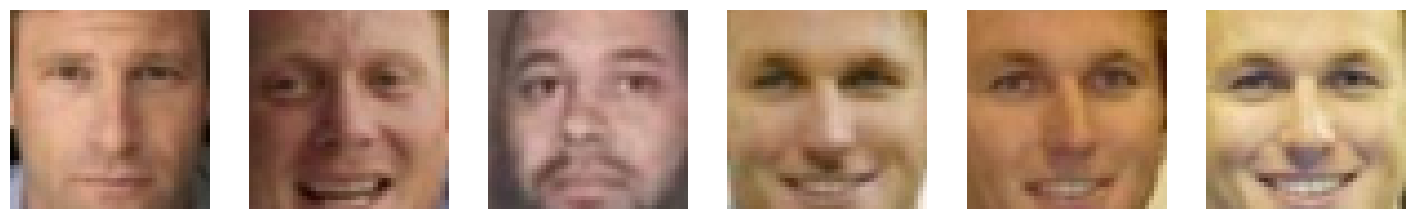

In [ ]:
import matplotlib.pyplot as plt
from IPython.display import clear_output

plt.figure(figsize=(18, 6))
for i in range(6):
    plt.subplot(2, 6, i+1)
    plt.axis("off")
    plt.imshow(images[i])

plt.show();

## 1.2. Архитектура модели (2 балла)
В этом разделе вы напишите и обучите обычный автоэнкодер.



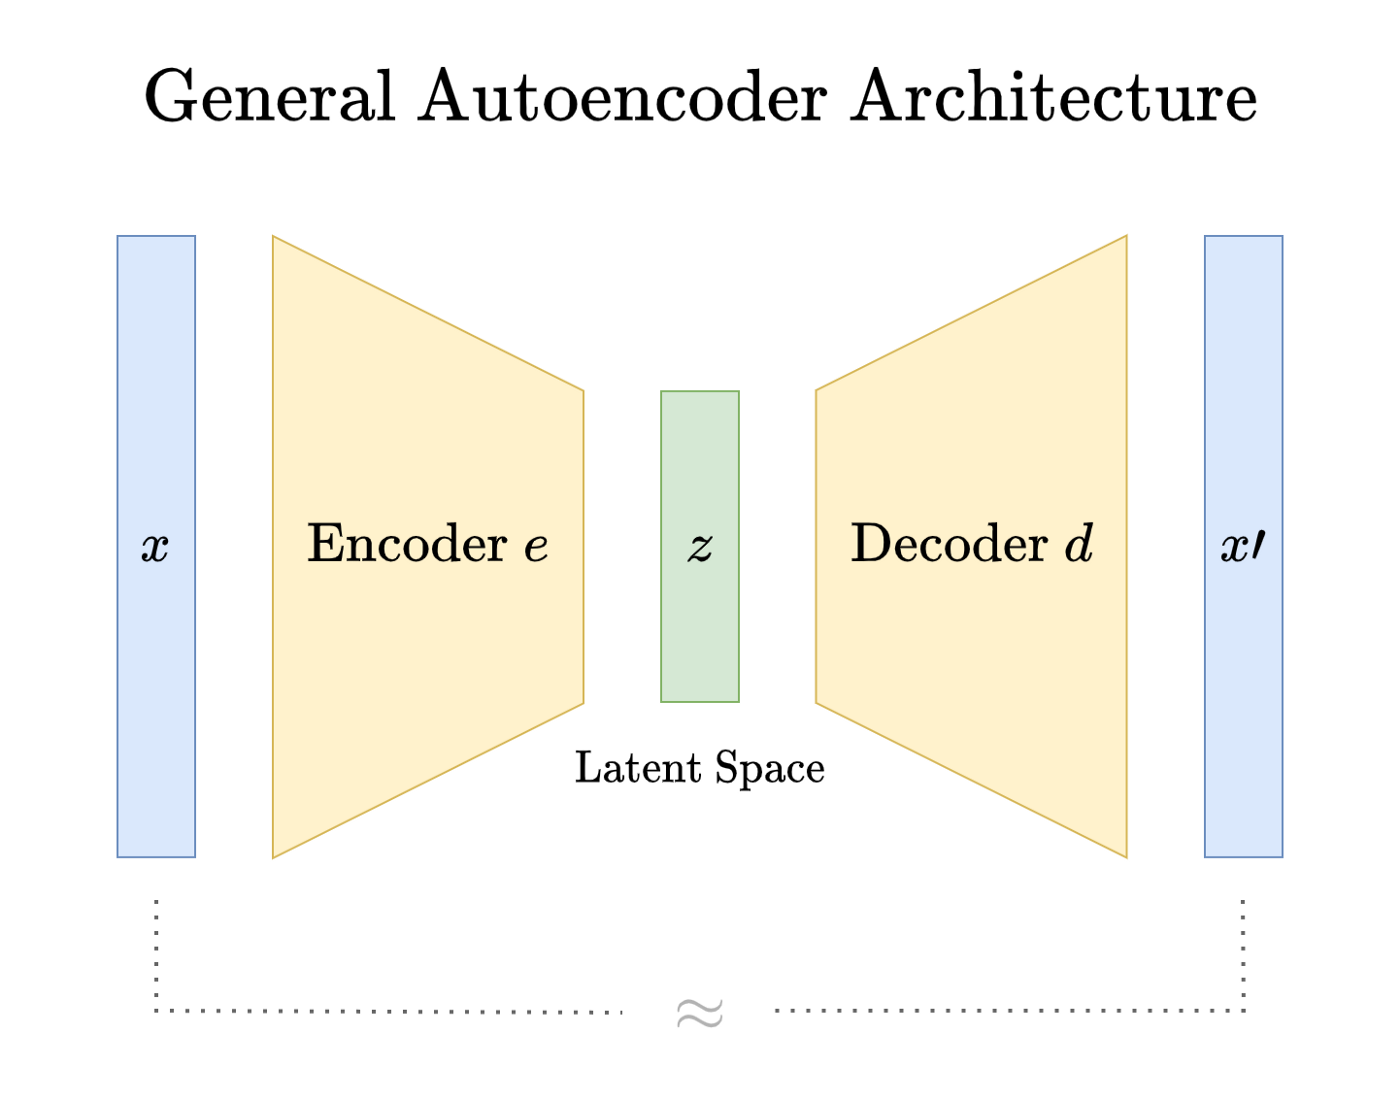

In [ ]:
features = 108 # выберите размер латентного вектора

Реализуем autoencoder. Архитектуру (conv, fully-connected, ReLu, etc) можете выбирать сами. Экспериментируйте!

In [ ]:
#input_dim = 45*45*3 = 6075

class Autoencoder(nn.Module):
    def __init__(self, features=108, input_dim=6075):
        super(Autoencoder, self).__init__()

        # encoder
        self.encoder = nn.Sequential(
            nn.Flatten(),
            nn.Linear(input_dim, 1215),
            nn.BatchNorm1d(1215),
            nn.ReLU(),

            nn.Linear(1215, 810),
            nn.BatchNorm1d(810),
            nn.ReLU(),

            nn.Linear(810, 540),
            nn.BatchNorm1d(540),
            nn.ReLU(),

            nn.Linear(540, features*2)
        )

        # decoder
        self.decoder = nn.Sequential(
            nn.Linear(features, 540),
            nn.BatchNorm1d(540),
            nn.ReLU(),

            nn.Linear(540, 810),
            nn.BatchNorm1d(810),
            nn.ReLU(),

            nn.Linear(810, 1215),
            nn.BatchNorm1d(1215),
            nn.ReLU(),

            nn.Linear(1215, input_dim),
            nn.Sigmoid()
        )

    def reparameterize(self, mu, log_var):
        """
        :param mu: mean from the encoder's latent space
        :param log_var: log variance from the encoder's latent space
        """
        std = torch.exp(0.5 * log_var) # standard deviation
        eps = torch.randn_like(std) # `randn_like` as we need the same size
        sample = mu + (eps * std) # sampling as if coming from the input space
        return sample

    def forward(self, x):
        # encoding
        x = self.encoder(x).view(-1, 2, features)
        # get `mu` and `log_var`
        mu = x[:, 0, :] # the first feature values as mean
        log_var = x[:, 1, :] # the other feature values as variance
        # get the latent vector through reparameterization
        z = self.reparameterize(mu, log_var)

        # decoding
        x = self.decoder(z)
        reconstruction = torch.sigmoid(x)
        return reconstruction, mu, log_var

    def get_latent_vector(self, x):
        x = self.encoder(x).view(-1, 2, features)
        # get `mu` and `log_var`
        mu = x[:, 0, :] # the first feature values as mean
        log_var = x[:, 1, :] # the other feature values as variance
        # get the latent vector through reparameterization
        z = self.reparameterize(mu, log_var)
        return z

    def sample(self, z):
        generated = self.decoder(z)
        generated = torch.sigmoid(generated)
        generated = generated.view(-1, 45, 45, 3)
        return generated

In [ ]:
def KL_divergence(mu, logsigma):
    """
    часть функции потерь, которая отвечает за "близость" латентных представлений разных людей
    """
    loss = -0.5 * torch.sum(1 + logsigma - mu.pow(2) - logsigma.exp())
    return loss

def log_likelihood(x, reconstruction):
    """
    часть функции потерь, которая отвечает за качество реконструкции
    """
    loss = nn.BCELoss(reduction='sum')
    return loss(reconstruction, x)

def loss_vae(x, mu, logsigma, reconstruction):
    return KL_divergence(mu, logsigma) + log_likelihood(x, reconstruction)

In [ ]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

criterion = loss_vae

autoencoder = Autoencoder().to(device)

optimizer = torch.optim.Adam(autoencoder.parameters())

In [ ]:
device

'cpu'

## 1.3 Обучение (2 балла)

Осталось написать код обучения автоэнкодера. При этом было бы неплохо в процессе иногда смотреть, как автоэнкодер реконструирует изображения на данном этапе обучения. Наример, после каждой эпохи (прогона train выборки через автоэнкодер) можно смотреть, какие реконструкции получились для каких-то изображений val выборки.

А, ну еще было бы неплохо выводить графики train и val лоссов в процессе тренировки =)

In [ ]:
from tqdm import tqdm

In [ ]:
train_images[0].shape

torch.Size([3, 45, 45])

In [ ]:
train_loader = torch.utils.data.DataLoader(train_images, batch_size=32)
val_loader = torch.utils.data.DataLoader(val_images, batch_size=32)

  0%|          | 0/20 [00:00<?, ?it/s]

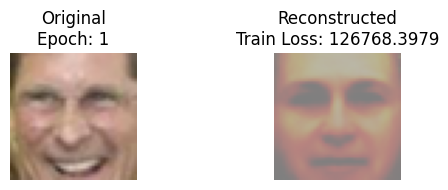

  5%|▌         | 1/20 [00:24<07:44, 24.43s/it]

Epoch 1/20 | Train Loss: 126768.3979 | Val Loss: 128989.7791


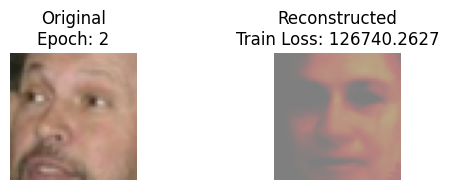

 10%|█         | 2/20 [00:48<07:16, 24.26s/it]

Epoch 2/20 | Train Loss: 126740.2627 | Val Loss: 128963.0258


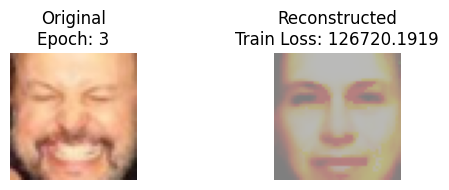

 15%|█▌        | 3/20 [01:13<06:57, 24.57s/it]

Epoch 3/20 | Train Loss: 126720.1919 | Val Loss: 128949.8101


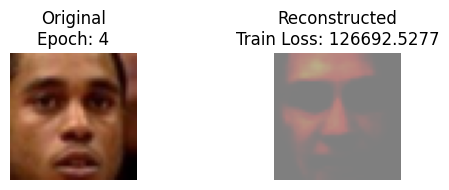

 20%|██        | 4/20 [01:37<06:31, 24.44s/it]

Epoch 4/20 | Train Loss: 126692.5277 | Val Loss: 128944.1004


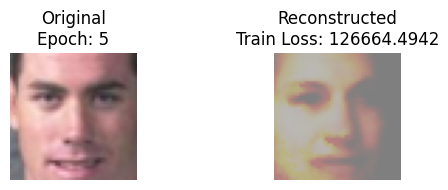

 25%|██▌       | 5/20 [02:01<06:05, 24.37s/it]

Epoch 5/20 | Train Loss: 126664.4942 | Val Loss: 128903.4740


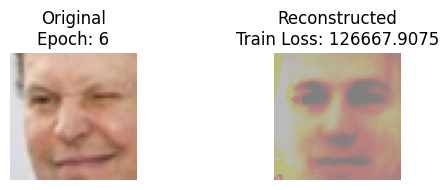

 30%|███       | 6/20 [02:26<05:40, 24.35s/it]

Epoch 6/20 | Train Loss: 126667.9075 | Val Loss: 129003.5309


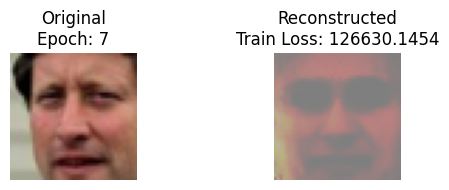

 35%|███▌      | 7/20 [02:50<05:16, 24.35s/it]

Epoch 7/20 | Train Loss: 126630.1454 | Val Loss: 128932.3083


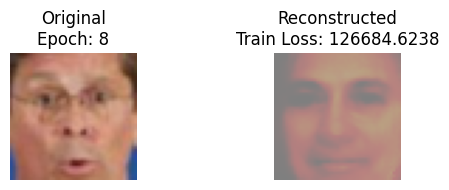

 40%|████      | 8/20 [03:15<04:53, 24.42s/it]

Epoch 8/20 | Train Loss: 126684.6238 | Val Loss: 128918.2719


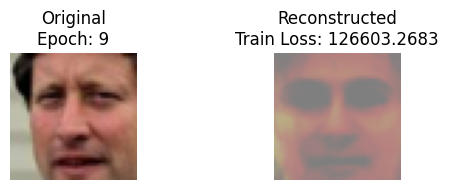

 45%|████▌     | 9/20 [03:39<04:28, 24.44s/it]

Epoch 9/20 | Train Loss: 126603.2683 | Val Loss: 128808.6819


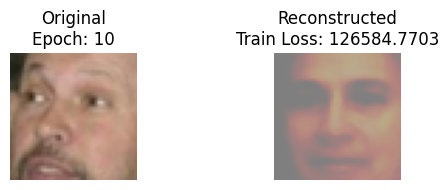

 50%|█████     | 10/20 [04:04<04:04, 24.42s/it]

Epoch 10/20 | Train Loss: 126584.7703 | Val Loss: 128820.0819


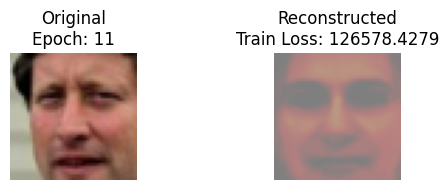

 55%|█████▌    | 11/20 [04:27<03:38, 24.25s/it]

Epoch 11/20 | Train Loss: 126578.4279 | Val Loss: 128954.4224


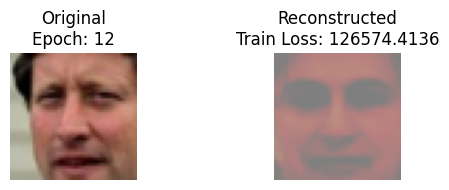

 60%|██████    | 12/20 [04:51<03:13, 24.16s/it]

Epoch 12/20 | Train Loss: 126574.4136 | Val Loss: 128825.9736


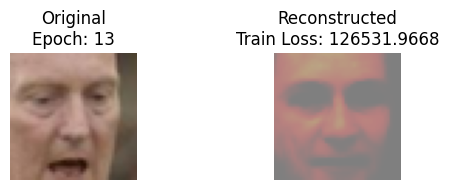

 65%|██████▌   | 13/20 [05:16<02:49, 24.15s/it]

Epoch 13/20 | Train Loss: 126531.9668 | Val Loss: 128780.2748


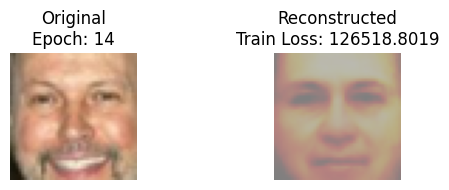

 70%|███████   | 14/20 [05:40<02:25, 24.18s/it]

Epoch 14/20 | Train Loss: 126518.8019 | Val Loss: 128793.7888


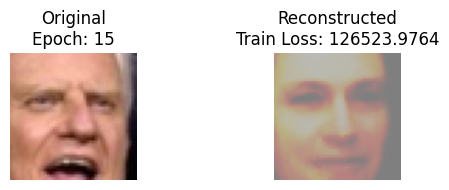

 75%|███████▌  | 15/20 [06:04<02:01, 24.21s/it]

Epoch 15/20 | Train Loss: 126523.9764 | Val Loss: 128859.1970


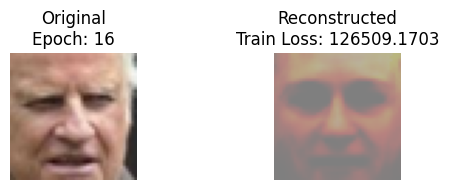

 80%|████████  | 16/20 [06:28<01:36, 24.19s/it]

Epoch 16/20 | Train Loss: 126509.1703 | Val Loss: 128905.3322


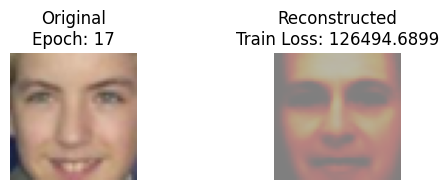

 85%|████████▌ | 17/20 [06:53<01:12, 24.25s/it]

Epoch 17/20 | Train Loss: 126494.6899 | Val Loss: 128898.9729


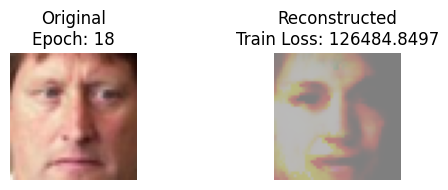

 90%|█████████ | 18/20 [07:17<00:48, 24.38s/it]

Epoch 18/20 | Train Loss: 126484.8497 | Val Loss: 128983.1883


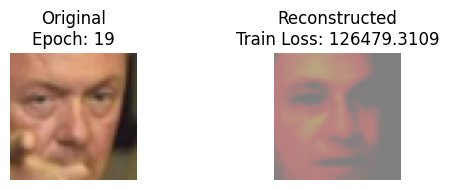

 95%|█████████▌| 19/20 [07:42<00:24, 24.42s/it]

Epoch 19/20 | Train Loss: 126479.3109 | Val Loss: 129139.9761


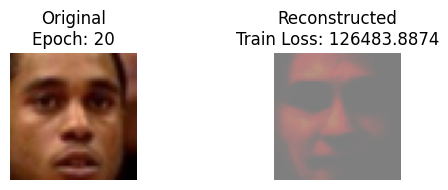

100%|██████████| 20/20 [08:06<00:00, 24.33s/it]

Epoch 20/20 | Train Loss: 126483.8874 | Val Loss: 128983.8635


In [ ]:
num_epochs = 20
train_losses = []
val_losses = []

for epoch in tqdm(range(num_epochs)):
    # Training phase
    autoencoder.train()
    train_losses_per_epoch = []
    for batch in train_loader:
        optimizer.zero_grad()
        reconstruction, mu, logsigma = autoencoder(batch.to(device))
        reconstruction = reconstruction.view(-1, 45, 45, 3).permute(0, 3, 1, 2)  # NHWC -> NCHW
        loss = criterion(batch.to(device).float(), mu, logsigma, reconstruction)
        loss.backward()
        optimizer.step()
        train_losses_per_epoch.append(loss.item())

    train_loss_mean = np.mean(train_losses_per_epoch)
    train_losses.append(train_loss_mean)

    # Validation phase
    autoencoder.eval()
    val_losses_per_epoch = []
    with torch.no_grad():
        for batch_idx, batch in enumerate(val_loader):
            reconstruction, mu, logsigma = autoencoder(batch.to(device))
            reconstruction = reconstruction.view(-1, 45, 45, 3)

            # Визуализация только для первого батча
            if batch_idx == 0 and epoch % 1 == 0:  # Показываем каждую эпоху
                # Выбираем случайное изображение из батча
                idx = np.random.randint(0, batch.size(0))

                # Подготовка изображений
                original_img = batch[idx].permute(1, 2, 0).cpu().numpy()
                reconstructed_img = reconstruction[idx].cpu().numpy()

                # Визуализация
                plt.figure(figsize=(6, 2))
                plt.subplot(1, 2, 1)
                plt.imshow(original_img)
                plt.title(f"Original\nEpoch: {epoch+1}")
                plt.axis('off')

                plt.subplot(1, 2, 2)
                plt.imshow(reconstructed_img)
                plt.title(f"Reconstructed\nTrain Loss: {train_loss_mean:.4f}")
                plt.axis('off')

                plt.tight_layout()
                plt.show()

            reconstruction = reconstruction.permute(0, 3, 1, 2)  # NHWC -> NCHW
            loss = criterion(batch.to(device).float(), mu, logsigma, reconstruction)
            val_losses_per_epoch.append(loss.item())

    val_loss_mean = np.mean(val_losses_per_epoch)
    val_losses.append(val_loss_mean)

   # Вывод значений лоссов
    print(f"Epoch {epoch+1}/{num_epochs} | Train Loss: {train_loss_mean:.4f} | Val Loss: {val_loss_mean:.4f}")

Что вы можете сказать про результат?

## 1.4. Sampling (2 балла)

Давайте теперь будем не просто брать картинку, прогонять ее через автоэнкодер и получать реконструкцию, а попробуем создать что-то НОВОЕ!

Давайте возьмем и подсунем декодеру какие-нибудь сгенерированные нами векторы (например, из нормального распределения) и посмотрим на результат реконструкции декодера:

__Подсказка:__ Если вместо лиц у вас выводится непонятно что, попробуйте посмотреть, как выглядят латентные векторы картинок из датасета. Так как в обучении нейронных сетей есть определенная доля рандома, векторы латентного слоя могут быть распределены НЕ как `np.random.randn(25, <latent_space_dim>)`. А чтобы у нас получались лица при запихивании вектора декодеру, вектор должен быть распределен так же, как латентные векторы реальных фоток. Так что в таком случае придется рандом немного подогнать.

In [ ]:
# сгенерируем 25 рандомных векторов размера latent_space
z = np.random.randn(25, 108)
output = autoencoder.sample(torch.FloatTensor(z).to(device))

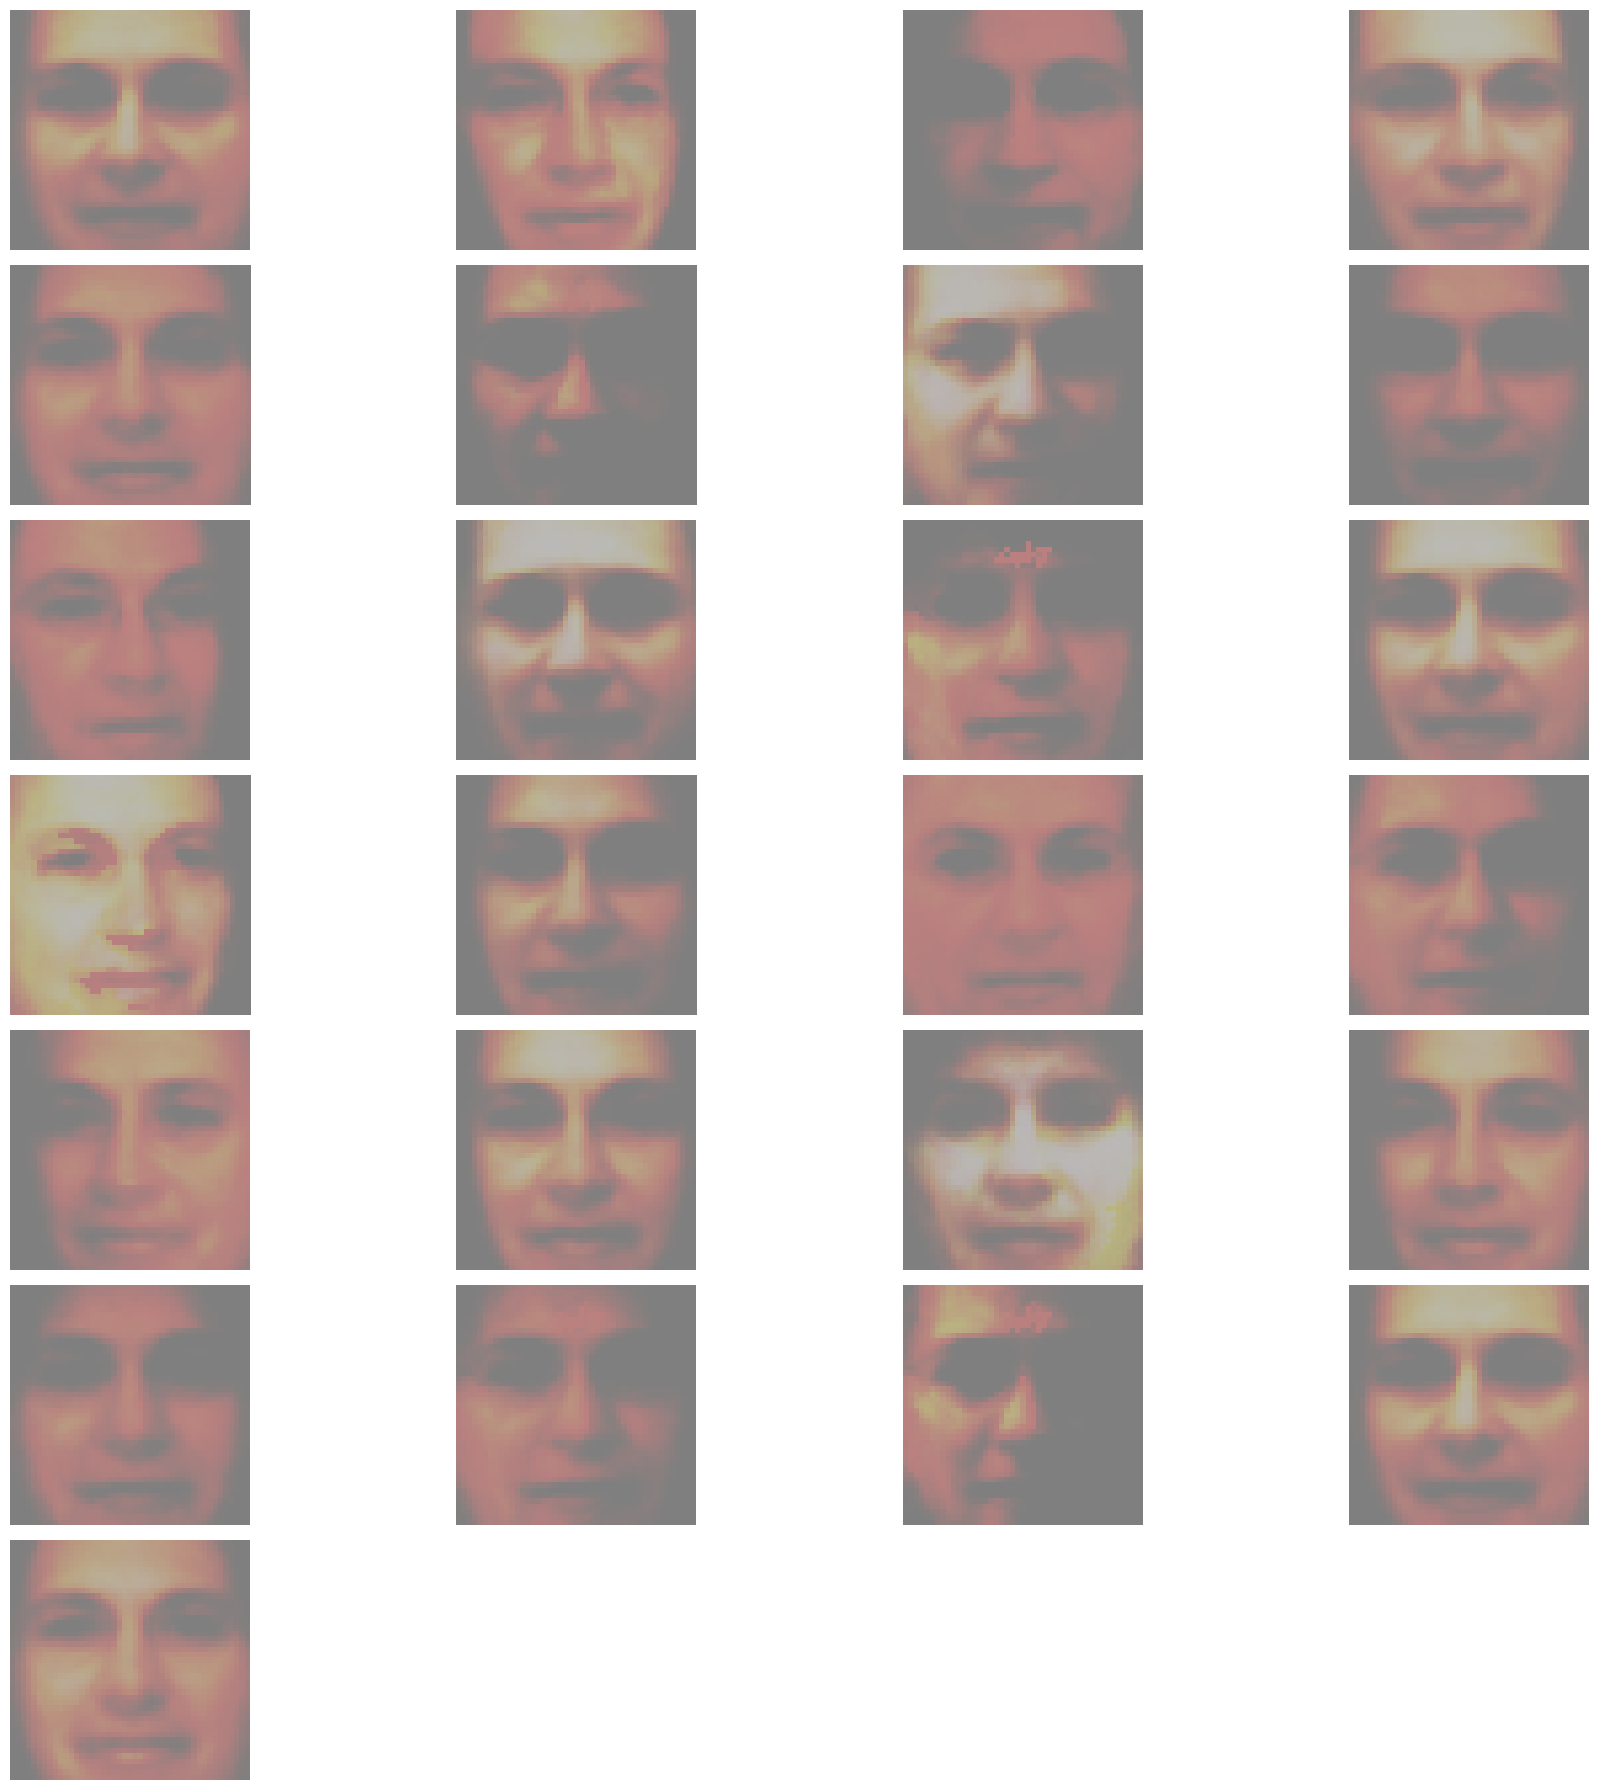

In [ ]:
plt.figure(figsize=(18, 18))

n = output.shape[0]
cols = 4
rows = int(np.ceil(n / cols))

for i in range(n):
    plt.subplot(rows, cols, i + 1)
    generated = output[i].cpu().detach().numpy()

    if generated.shape[0] == 3 or generated.shape[0] == 1:
        generated = generated.transpose(1, 2, 0)

    plt.imshow(generated)
    plt.axis('off')

plt.tight_layout()
plt.show()

## 1.5 Time to make fun! (3 балла)

Давайте научимся пририсовывать людям улыбки =)

<img src="https://i.imgur.com/tOE9rDK.png" alt="linear" width="700" height="400">

План такой:

1. Нужно выделить "вектор улыбки": для этого нужно из выборки изображений найти несколько (~15) людей с улыбками и столько же без.

Найти людей с улыбками вам поможет файл с атрибутами, скачанный вместе с картинками. В нем указаны имена изображений и присутствубщие атрибуты (улыбки, очки и прочее интересное).

2. Вычислить латентный вектор для всех улыбающихся людей (прогнать их через encoder) и то же для всех грустненьких.

3. Вычислить, собственно, вектор улыбки -- посчитать разность между средним латентным вектором улыбающихся людей и средним латентным вектором грустных людей.

4. А теперь приделаем улыбку грустному человеку: добавим полученный в пункте 3 вектор к латентному вектору грустного человека и прогоним полученный вектор через decoder. Получим того же человека, но уже не грустненького!

In [ ]:
# attrs: 'Smiling','Frowning'
smile_idx = attrs['Smiling'].sort_values(ascending=False).iloc[:15].index
frow_idx = attrs['Frowning'].sort_values(ascending=False).iloc[:15].index

In [ ]:
smile_images = []
frow_images = []
for i, idx in enumerate(smile_idx):
    smile_images.append(images[idx])

for i, idx in enumerate(frow_idx):
    frow_images.append(images[idx])

array([[[254, 253, 248],
        [243, 239, 238],
        [179, 168, 174],
        ...,
        [211, 151, 121],
        [207, 147, 118],
        [207, 148, 123]],

       [[255, 253, 248],
        [244, 239, 239],
        [173, 163, 168],
        ...,
        [206, 147, 116],
        [203, 143, 114],
        [202, 146, 121]],

       [[255, 254, 250],
        [240, 235, 235],
        [162, 153, 155],
        ...,
        [202, 143, 114],
        [200, 141, 113],
        [202, 146, 121]],

       ...,

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [181, 124, 104],
        [168, 111,  92],
        [160, 103,  84]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [175, 118,  99],
        [162, 105,  86],
        [159, 102,  83]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [172, 115,  96],
        [162, 105,  86],
        [157, 100,  81]]], dtype=uint8)
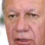

In [ ]:
frow_images[0]

In [ ]:
transform = transforms.Compose([
    transforms.ToTensor(),
])

smile_images_tensor = torch.stack([transform(img) for img in smile_images])
frow_images_tensor = torch.stack([transform(img) for img in frow_images])

In [ ]:
len(smile_images_tensor)

15

Вычисляем латентные вектора для улыбающихся и хмурых

In [ ]:
smile_latent_vectors = []
loader = torch.utils.data.DataLoader(smile_images_tensor, batch_size=1)
autoencoder.eval()
with torch.no_grad():
    for batch_idx, batch in enumerate(loader):
        latent_vector = autoencoder.get_latent_vector(batch.to(device))
        smile_latent_vectors.append(latent_vector)

In [ ]:
frow_latent_vectors = []
loader = torch.utils.data.DataLoader(frow_images_tensor, batch_size=1)
autoencoder.eval()
with torch.no_grad():
    for batch_idx, batch in enumerate(loader):
        latent_vector = autoencoder.get_latent_vector(batch.to(device))
        frow_latent_vectors.append(latent_vector)

Считаем вектор улыбки

In [ ]:
mean_smile_vector = sum(smile_latent_vectors)/len(smile_latent_vectors)
mean_frow_vector = sum(frow_latent_vectors)/len(frow_latent_vectors)
smile_vector = mean_smile_vector - mean_frow_vector

Новые латентные векторы с добавлением улыбок

In [ ]:
frow_to_smile_latent_vectors = []
for el in frow_latent_vectors:
    frow_to_smile_latent_vectors.append(el+smile_vector)

Добавляем улыбки

In [ ]:
outputs=[]

for i in range(15):
    outputs.append(autoencoder.sample(frow_to_smile_latent_vectors[i].to(device)))

In [ ]:
outputs[0].shape

torch.Size([1, 45, 45, 3])

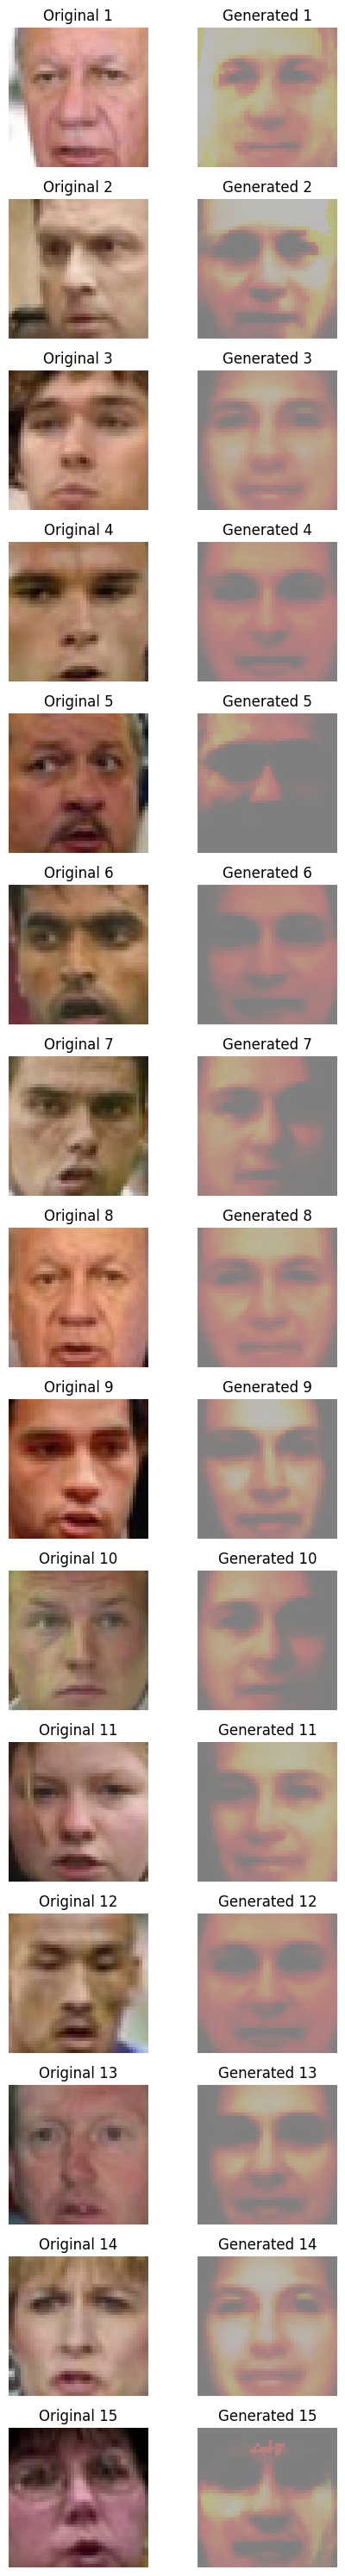

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def plot_pairs(frow_images, outputs, n_pairs=15):
    fig, axes = plt.subplots(n_pairs, 2, figsize=(5, 2*n_pairs))

    for i in range(n_pairs):
        # Оригинальное изображение (уже в numpy)
        orig_img = frow_images[i]

        # Сгенерированное изображение (конвертируем из тензора)
        gen_img = outputs[i].squeeze(0).cpu().detach().numpy()

        # Нормализация, если нужно
        if gen_img.max() > 1.0:
            gen_img = gen_img / gen_img.max()

        # Отрисовка
        axes[i, 0].imshow(orig_img)
        axes[i, 0].set_title(f'Original {i+1}')
        axes[i, 0].axis('off')

        axes[i, 1].imshow(gen_img)
        axes[i, 1].set_title(f'Generated {i+1}')
        axes[i, 1].axis('off')

    plt.tight_layout()
    plt.show()

# Пример вызова
plot_pairs(frow_images, outputs)

Вуаля! Вы восхитительны!

Теперь вы можете пририсовывать людям не только улыбки, но и много чего другого -- закрывать/открывать глаза, пририсовывать очки... В общем, все, на что хватит фантазии и на что есть атрибуты в `attrs`:)

# Часть 2: Variational Autoencoder (10 баллов)

Займемся обучением вариационных автоэнкодеров — проапгрейженной версии AE. Обучать будем на датасете MNIST, содержащем написанные от руки цифры от 0 до 9

In [5]:
batch_size = 32
# MNIST Dataset
train_dataset = datasets.MNIST(root='./mnist_data/', train=True, transform=transforms.ToTensor(), download=True)
test_dataset = datasets.MNIST(root='./mnist_data/', train=False, transform=transforms.ToTensor(), download=False)

# Data Loader (Input Pipeline)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

100%|██████████| 9.91M/9.91M [00:00<00:00, 59.7MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 1.77MB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 14.6MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 6.00MB/s]


In [ ]:
sample, label = train_dataset[0]

print(f"Размер одного элемента: {sample.shape}")  # Выведет: torch.Size([1, 28, 28])
print(f"Соответствующая метка: {label}")  # Выведет цифру от 0 до 9

Размер одного элемента: torch.Size([1, 28, 28])
Соответствующая метка: 5


In [16]:
train_dataset[122][0]

tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.1529, 0.8941, 0.9961, 0.8784, 0.1373,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.8078, 0.9922, 0.9922, 0.9922, 0.8706,
          0.3804, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,

## 2.1 Архитектура модели и обучение (2 балла)

Реализуем VAE. Архитектуру (conv, fully-connected, ReLu, etc) можете выбирать сами. Рекомендуем пользоваться более сложными моделями, чем та, что была на семинаре:) Экспериментируйте!

In [ ]:
#input_dim = 1*28*28 = 784
class VAE(nn.Module):
    def __init__(self, features=50, input_dim=784):
        super(VAE, self).__init__()

        # encoder
        self.encoder = nn.Sequential(
            nn.Flatten(),
            nn.Linear(input_dim, 560),
            nn.BatchNorm1d(560),
            nn.ReLU(),

            nn.Linear(560, 350),
            nn.BatchNorm1d(350),
            nn.ReLU(),

            nn.Linear(350, 200),
            nn.BatchNorm1d(200),
            nn.ReLU(),

            nn.Linear(200, features*2)
        )

        # decoder
        self.decoder = nn.Sequential(
            nn.Linear(features, 200),
            nn.BatchNorm1d(200),
            nn.ReLU(),

            nn.Linear(200, 350),
            nn.BatchNorm1d(350),
            nn.ReLU(),

            nn.Linear(350, 560),
            nn.BatchNorm1d(560),
            nn.ReLU(),

            nn.Linear(560, input_dim),
            nn.Sigmoid()
        )

    def encode(self, x):
        encoded = self.encoder(x)
        mu, logsigma = encoded.chunk(2, dim=1)
        return mu, logsigma

    def gaussian_sampler(self, mu, logsigma):
        if self.training:
            std = torch.exp(0.5 * logsigma)
            eps = torch.randn_like(std)
            return mu + eps * std
        else:
            return mu

    def decode(self, z):
        reconstruction = self.decoder(z)
        return reconstruction

    def forward(self, x):
        mu, logsigma = self.encode(x)
        z = self.gaussian_sampler(mu, logsigma)
        reconstruction = self.decode(z)
        return reconstruction, mu, logsigma

    def get_latent_vector(self, x):
        mu, logsigma = self.encode(x)
        z = self.gaussian_sampler(mu, logsigma)
        return z

    def sample(self, z):
        generated = self.decoder(z)
        generated = torch.sigmoid(generated)
        generated = generated.view(-1, 28, 28, 1)
        return generated

    def reparameterize(self, mu, log_var):
        """Альтернативное название для gaussian_sampler"""
        return self.gaussian_sampler(mu, log_var)

Определим лосс и его компоненты для VAE:

Надеюсь, вы уже прочитали материал в towardsdatascience (или еще где-то) про VAE и знаете, что лосс у VAE состоит из двух частей: KL и log-likelihood.

Общий лосс будет выглядеть так:

$$\mathcal{L} = -D_{KL}(q_{\phi}(z|x)||p(z)) + \log p_{\theta}(x|z)$$

Формула для KL-дивергенции:

$$D_{KL} = -\frac{1}{2}\sum_{i=1}^{dimZ}(1+log(\sigma_i^2)-\mu_i^2-\sigma_i^2)$$

В качестве log-likelihood возьмем привычную нам кросс-энтропию.

In [4]:
def KL_divergence(mu, logsigma):
    return -0.5 * torch.sum(1 + logsigma - mu.pow(2) - logsigma.exp(), dim=1)

def log_likelihood(x, reconstruction):

    if x.dim() > 2:
        x = x.view(x.size(0), -1)
    if reconstruction.dim() > 2:
        reconstruction = reconstruction.view(reconstruction.size(0), -1)

    bce = F.binary_cross_entropy(reconstruction, x, reduction='none').sum(dim=1)
    return bce

def loss_vae(x, mu, logsigma, reconstruction):
    recon_loss = log_likelihood(x, reconstruction)
    kl_loss = KL_divergence(mu, logsigma)

    total_loss = (recon_loss + kl_loss).mean()

    return total_loss

И обучим модель:

In [ ]:
loss_function = loss_vae

autoencoder = VAE()

optimizer = torch.optim.Adam(autoencoder.parameters())

criterion = loss_vae

In [ ]:
device = 'cpu'

Training VAE:   0%|          | 0/20 [00:00<?, ?it/s]

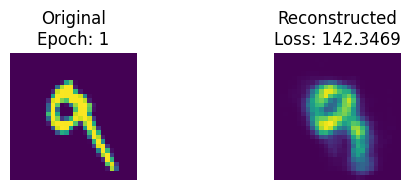

Training VAE:   5%|▌         | 1/20 [00:36<11:37, 36.71s/it]

Epoch 1/20 | Train Loss: 142.3469 | Val Loss: 113.0967


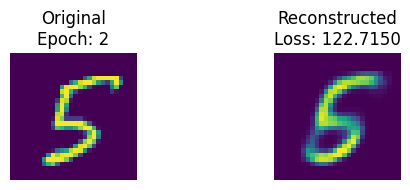

Training VAE:  10%|█         | 2/20 [01:13<11:01, 36.77s/it]

Epoch 2/20 | Train Loss: 122.7150 | Val Loss: 107.2839


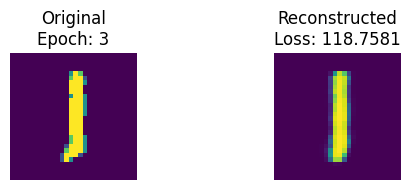

Training VAE:  15%|█▌        | 3/20 [01:50<10:23, 36.67s/it]

Epoch 3/20 | Train Loss: 118.7581 | Val Loss: 104.5637


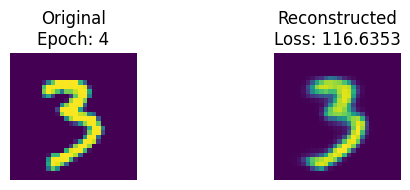

Training VAE:  20%|██        | 4/20 [02:27<09:48, 36.80s/it]

Epoch 4/20 | Train Loss: 116.6353 | Val Loss: 102.8457


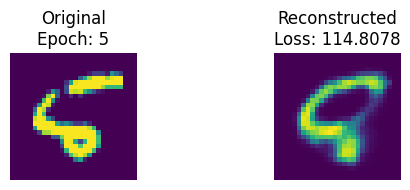

Training VAE:  25%|██▌       | 5/20 [03:03<09:10, 36.70s/it]

Epoch 5/20 | Train Loss: 114.8078 | Val Loss: 101.2988


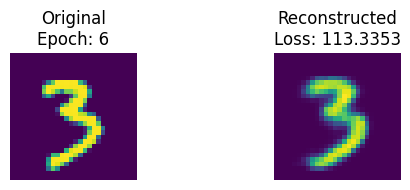

Training VAE:  30%|███       | 6/20 [03:39<08:31, 36.51s/it]

Epoch 6/20 | Train Loss: 113.3353 | Val Loss: 100.5524


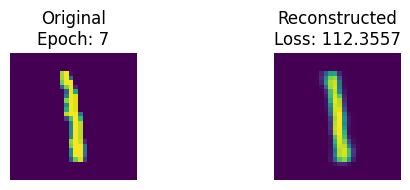

Training VAE:  35%|███▌      | 7/20 [04:15<07:52, 36.34s/it]

Epoch 7/20 | Train Loss: 112.3557 | Val Loss: 99.6513


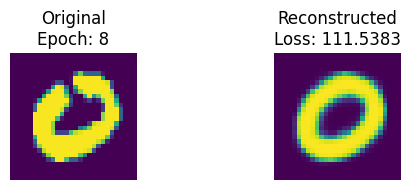

Training VAE:  40%|████      | 8/20 [04:51<07:15, 36.31s/it]

Epoch 8/20 | Train Loss: 111.5383 | Val Loss: 99.2736


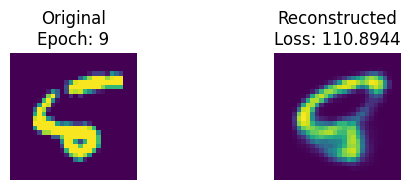

Training VAE:  45%|████▌     | 9/20 [05:28<06:40, 36.40s/it]

Epoch 9/20 | Train Loss: 110.8944 | Val Loss: 99.1052


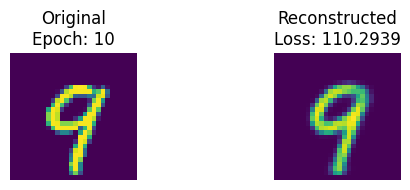

Training VAE:  50%|█████     | 10/20 [06:05<06:04, 36.48s/it]

Epoch 10/20 | Train Loss: 110.2939 | Val Loss: 98.4262


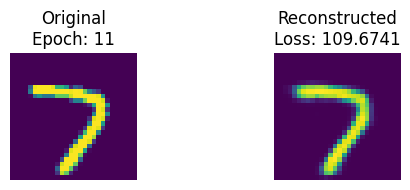

Training VAE:  55%|█████▌    | 11/20 [06:40<05:26, 36.26s/it]

Epoch 11/20 | Train Loss: 109.6741 | Val Loss: 97.8450


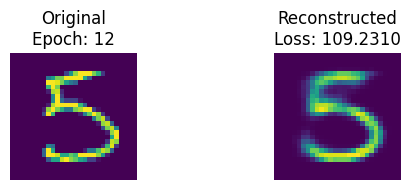

Training VAE:  60%|██████    | 12/20 [07:16<04:49, 36.14s/it]

Epoch 12/20 | Train Loss: 109.2310 | Val Loss: 97.8044


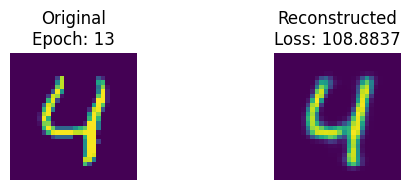

Training VAE:  65%|██████▌   | 13/20 [07:52<04:12, 36.12s/it]

Epoch 13/20 | Train Loss: 108.8837 | Val Loss: 97.5484


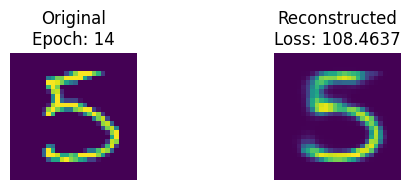

Training VAE:  70%|███████   | 14/20 [08:28<03:36, 36.04s/it]

Epoch 14/20 | Train Loss: 108.4637 | Val Loss: 97.4964


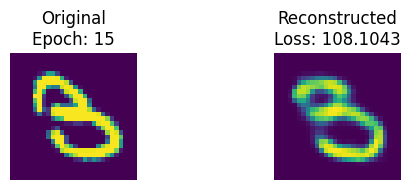

Training VAE:  75%|███████▌  | 15/20 [09:05<03:00, 36.11s/it]

Epoch 15/20 | Train Loss: 108.1043 | Val Loss: 96.7208


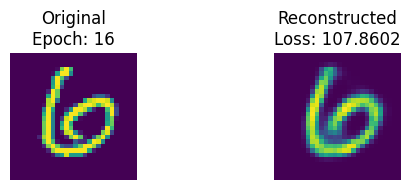

Training VAE:  80%|████████  | 16/20 [09:41<02:24, 36.08s/it]

Epoch 16/20 | Train Loss: 107.8602 | Val Loss: 96.7290


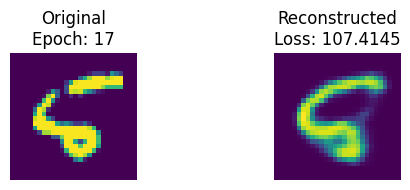

Training VAE:  85%|████████▌ | 17/20 [10:16<01:47, 35.96s/it]

Epoch 17/20 | Train Loss: 107.4145 | Val Loss: 96.2850


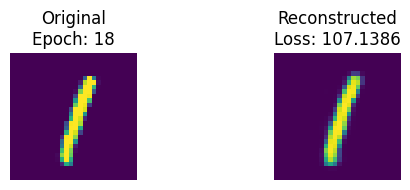

Training VAE:  90%|█████████ | 18/20 [10:52<01:11, 35.86s/it]

Epoch 18/20 | Train Loss: 107.1386 | Val Loss: 96.0302


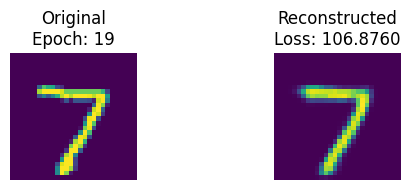

Training VAE:  95%|█████████▌| 19/20 [11:28<00:35, 35.82s/it]

Epoch 19/20 | Train Loss: 106.8760 | Val Loss: 96.3147


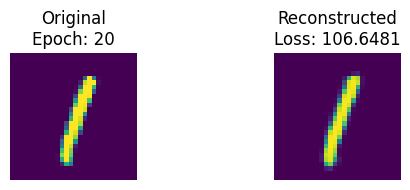

Training VAE: 100%|██████████| 20/20 [12:03<00:00, 36.18s/it]

Epoch 20/20 | Train Loss: 106.6481 | Val Loss: 96.3158


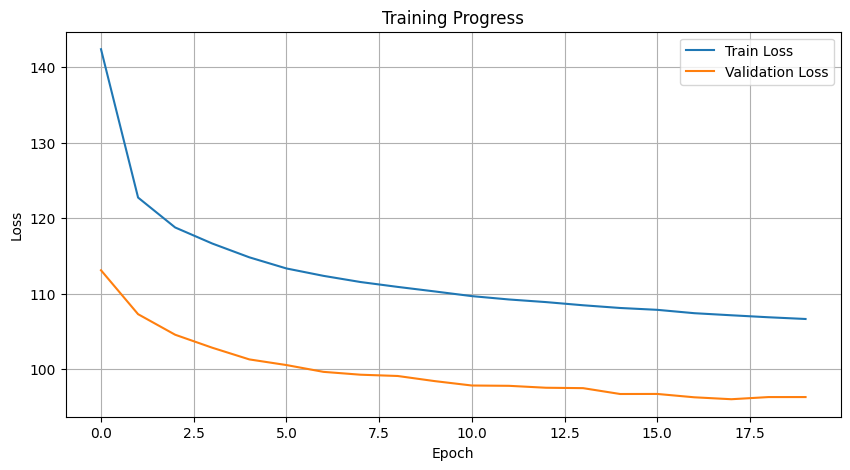

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import torch
import torch.optim as optim
from torchvision import transforms
from torch.utils.data import DataLoader

num_epochs = 20
batch_size = 32
train_losses = []
val_losses = []

for epoch in tqdm(range(num_epochs), desc='Training VAE'):
    autoencoder.train()
    train_losses_per_epoch = []

    for batch, _ in train_loader:
        batch = batch.to(device)

        optimizer.zero_grad()
        reconstruction, mu, logsigma = autoencoder(batch)

        reconstruction_flat = reconstruction.view(-1, 28*28*1)
        batch_flat = batch.view(-1, 28*28*1)

        loss = criterion(batch_flat, mu, logsigma, reconstruction_flat)

        loss.backward()
        optimizer.step()

        train_losses_per_epoch.append(loss.item())

    train_loss_mean = np.mean(train_losses_per_epoch)
    train_losses.append(train_loss_mean)

    # Validation phase
    autoencoder.eval()
    val_losses_per_epoch = []

    with torch.no_grad():
        for batch_idx, (batch, _) in enumerate(test_loader):
            batch = batch.to(device)

            reconstruction, mu, logsigma = autoencoder(batch)

            reconstruction_img = reconstruction.view(-1, 28, 28, 1)

            if batch_idx == 0 and epoch % 1 == 0:
                idx = np.random.randint(0, batch.size(0))

                # Подготовка изображений
                original_img = batch[idx].permute(1, 2, 0).cpu().numpy()
                reconstructed_img = reconstruction_img[idx].cpu().numpy()

                # Визуализация
                plt.figure(figsize=(6, 2))
                plt.subplot(1, 2, 1)
                plt.imshow(original_img)
                plt.title(f"Original\nEpoch: {epoch+1}")
                plt.axis('off')

                plt.subplot(1, 2, 2)
                plt.imshow(reconstructed_img)
                plt.title(f"Reconstructed\nLoss: {train_loss_mean:.4f}")
                plt.axis('off')

                plt.tight_layout()
                plt.show()

            # Compute validation loss
            reconstruction_flat = reconstruction.view(-1, 28, 28, 1)
            batch_flat = batch.view(-1, 28*28*1)
            loss = criterion(batch_flat, mu, logsigma, reconstruction_flat)
            val_losses_per_epoch.append(loss.item())

    val_loss_mean = np.mean(val_losses_per_epoch)
    val_losses.append(val_loss_mean)

    # Вывод статистики
    print(f"Epoch {epoch+1}/{num_epochs} | Train Loss: {train_loss_mean:.4f} | Val Loss: {val_loss_mean:.4f}")

# Визуализация кривых обучения
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Progress')
plt.legend()
plt.grid()
plt.show()

Давайте посмотрим, как наш тренированный VAE кодирует и восстанавливает картинки:

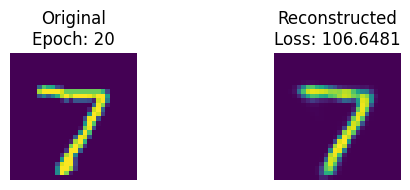

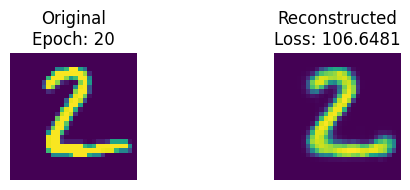

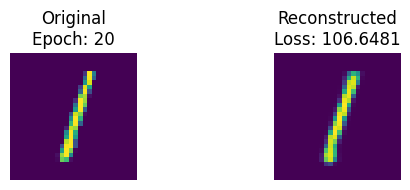

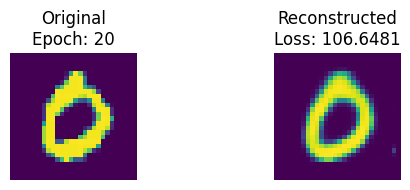

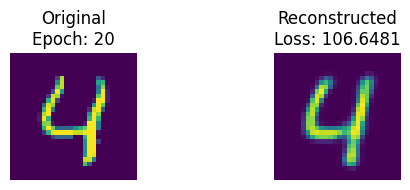

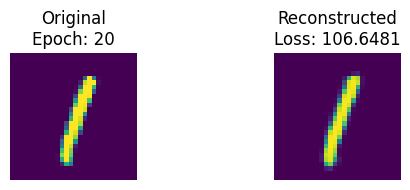

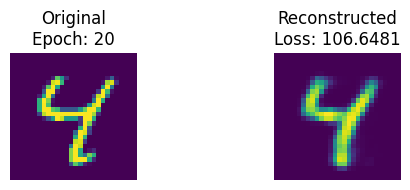

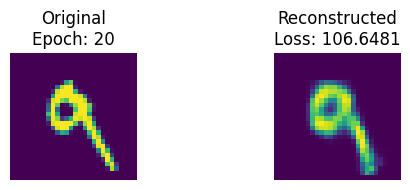

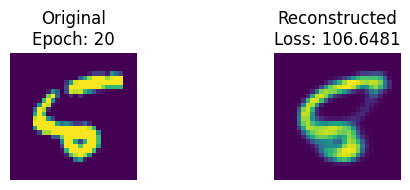

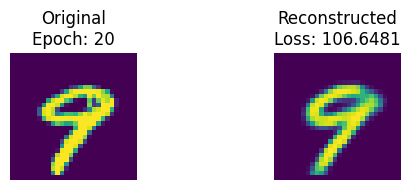

In [ ]:
#тут Ваш код: выведите первые Х картинок и их реконструкций из val выборки на экран
X = 10
autoencoder.eval()
with torch.no_grad():
  for idx in range(X):

    reconstruction, mu, logsigma = autoencoder(test_dataset[idx][0])
    reconstruction_img = reconstruction.view(-1, 28, 28, 1)

    original_img = test_dataset[idx][0].permute(1, 2, 0).cpu().numpy()
    reconstructed_img = reconstruction_img[0].cpu().numpy()

    plt.figure(figsize=(6, 2))
    plt.subplot(1, 2, 1)
    plt.imshow(original_img)
    plt.title(f"Original\nEpoch: {epoch+1}")
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(reconstructed_img)
    plt.title(f"Reconstructed\nLoss: {train_loss_mean:.4f}")
    plt.axis('off')

    plt.tight_layout()
    plt.show()

Давайте попробуем проделать для VAE то же, что и с обычным автоэнкодером -- подсунуть decoder'у из VAE случайные векторы из нормального распределения и посмотреть, какие картинки получаются:

In [ ]:
# вспомните про замечание из этого же пункта обычного AE про распределение латентных переменных
z = np.array([np.random.normal(0, 1, 50) for i in range(10)])
output = autoencoder.sample(torch.FloatTensor(z).to(device))

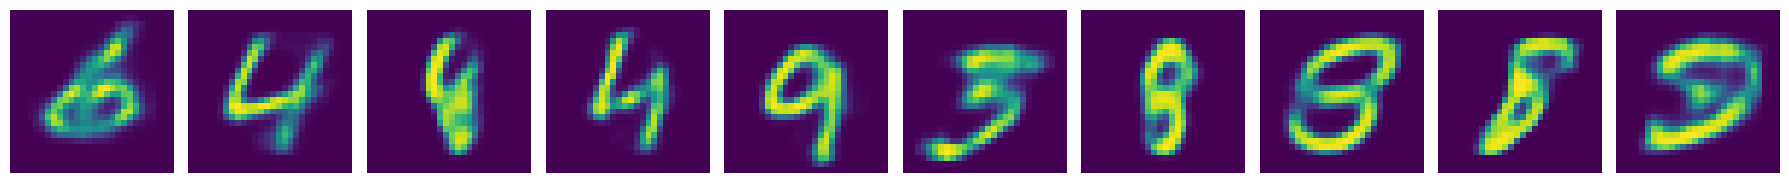

In [ ]:
plt.figure(figsize=(18, 18))

n = output.shape[0]
cols = 10
rows = int(np.ceil(n / cols))

for i in range(n):
    plt.subplot(rows, cols, i + 1)
    generated = output[i].cpu().detach().numpy()

    if generated.shape[0] == 3 or generated.shape[0] == 1:
        generated = generated.transpose(1, 2, 0)

    plt.imshow(generated)
    plt.axis('off')

plt.tight_layout()
plt.show()

## 2.2. Latent Representation (2 балла)

Давайте посмотрим, как латентные векторы картинок лиц выглядят в пространстве.
Ваша задача -- изобразить латентные векторы картинок точками в двумерном просторанстве.

Это позволит оценить, насколько плотно распределены латентные векторы изображений цифр в пространстве.

Плюс давайте сделаем такую вещь: покрасим точки, которые соответствуют картинкам каждой цифры, в свой отдельный цвет

Подсказка: красить -- это просто =) У plt.scatter есть параметр c (color), см. в документации.


Итак, план:
1. Получить латентные представления картинок тестового датасета
2. С помощтю `TSNE` (есть в `sklearn`) сжать эти представления до размерности 2 (чтобы можно было их визуализировать точками в пространстве)
3. Визуализировать полученные двумерные представления с помощью `matplotlib.scatter`, покрасить разными цветами точки, соответствующие картинкам разных цифр.

In [ ]:
test_dataset[0][1]

7

In [ ]:
import sklearn

In [ ]:
latent_vectors = []
autoencoder.eval()
with torch.no_grad():
  for idx in range(10000):
    latent_vectors.append(autoencoder.get_latent_vector(test_dataset[idx][0]))

In [ ]:
vectors = np.squeeze(np.array(latent_vectors))

In [ ]:
vectors.shape

(10000, 50)

In [ ]:
vectors_embedded = sklearn.manifold.TSNE(n_components=2, learning_rate='auto', init='random', perplexity=3).fit_transform(vectors)

In [ ]:
labels = []
for i in range(10000):
  labels.append(test_dataset[i][1])

In [ ]:
import numpy as np

coord_dict = {i: np.array([vec for lbl, vec in zip(labels, vectors_embedded) if lbl == i])
              for i in range(10)}

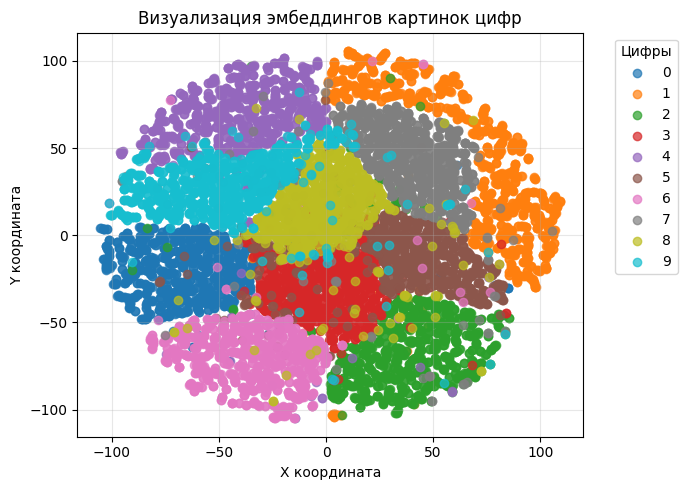

In [ ]:
plt.figure(figsize=(7, 5))

colors = plt.cm.tab10(np.linspace(0, 1, 10))

for digit in range(10):
      x = coord_dict[digit][:, 0]
      y = coord_dict[digit][:, 1]
      plt.scatter(x, y, color=colors[digit], label=str(digit), alpha=0.7)

plt.title('Визуализация эмбеддингов картинок цифр')
plt.xlabel('X координата')
plt.ylabel('Y координата')
plt.legend(title='Цифры', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, alpha=0.3)
plt.tight_layout()

plt.show()

Что вы думаете о виде латентного представления?

__Congrats v2.0!__

## 2.3. Conditional VAE (6 баллов)


Мы уже научились обучать обычный AE на датасете картинок и получать новые картинки, используя генерацию шума и декодер.
Давайте теперь допустим, что мы обучили AE на датасете MNIST и теперь хотим генерировать новые картинки с числами с помощью декодера (как выше мы генерили рандомные лица).
И вот нам понадобилось сгенерировать цифру 8, и мы подставляем разные варианты шума, но восьмерка никак не генерится:(

Хотелось бы добавить к нашему AE функцию "выдай мне рандомное число из вот этого вот класса", где классов десять (цифры от 0 до 9 образуют десять классов).  Conditional AE — так называется вид автоэнкодера, который предоставляет такую возможность. Ну, название "conditional" уже говорит само за себя.

И в этой части задания мы научимся такие обучать.

### Архитектура

На картинке ниже представлена архитектура простого Conditional VAE.

По сути, единственное отличие от обычного -- это то, что мы вместе с картинкой в первом слое энкодера и декодера передаем еще информацию о классе картинки.

То есть, в первый (входной) слой энкодера подается конкатенация картинки и информации о классе (например, вектора из девяти нулей и одной единицы). В первый слой декодера подается конкатенация латентного вектора и информации о классе.


![alt text](https://sun9-63.userapi.com/impg/Mh1akf7mfpNoprrSWsPOouazSmTPMazYYF49Tw/djoHNw_9KVA.jpg?size=1175x642&quality=96&sign=e88baec5f9bb91c8443fba31dcf0a4df&type=album)

![alt text](https://sun9-73.userapi.com/impg/UDuloLNKhzTBYAKewgxke5-YPsAKyGOqA-qCRg/MnyCavJidxM.jpg?size=1229x651&quality=96&sign=f2d21bfacc1c5755b76868dc4cfef39c&type=album)



На всякий случай: это VAE, то есть, latent у него все еще состоит из mu и sigma

Таким образом, при генерации новой рандомной картинки мы должны будем передать декодеру сконкатенированные латентный вектор и класс картинки.

P.S. Также можно передавать класс картинки не только в первый слой, но и в каждый слой сети. То есть на каждом слое конкатенировать выход из предыдущего слоя и информацию о классе.

In [53]:
class CVAE(nn.Module):
    def __init__(self, features=50, input_dim=784, num_classes=10):
        super(CVAE, self).__init__()
        self.features = features
        self.input_dim = input_dim
        self.num_classes = num_classes

        self.encoder = nn.Sequential(
            nn.Flatten(),
            nn.Linear(input_dim + num_classes, 560),
            nn.BatchNorm1d(560),
            nn.ReLU(),

            nn.Linear(560, 350),
            nn.BatchNorm1d(350),
            nn.ReLU(),

            nn.Linear(350, 200),
            nn.BatchNorm1d(200),
            nn.ReLU(),

            nn.Linear(200, features*2)
        )

        self.decoder = nn.Sequential(
            nn.Linear(features + num_classes, 200),
            nn.BatchNorm1d(200),
            nn.ReLU(),

            nn.Linear(200, 350),
            nn.BatchNorm1d(350),
            nn.ReLU(),

            nn.Linear(350, 560),
            nn.BatchNorm1d(560),
            nn.ReLU(),

            nn.Linear(560, input_dim),
            nn.Sigmoid()
        )

    def encode(self, x, class_num):
        class_vector = torch.zeros(x.size(0), self.num_classes, device=x.device)
        class_vector.scatter_(1, class_num.unsqueeze(1), 1)

        x_flat = torch.flatten(x, start_dim=1)
        x_combined = torch.cat([x_flat, class_vector], dim=1)

        encoded = self.encoder(x_combined)
        mu, logsigma = encoded.chunk(2, dim=1)
        return mu, logsigma

    def gaussian_sampler(self, mu, logsigma):
        if self.training:
            std = torch.exp(0.5 * logsigma)
            eps = torch.randn_like(std)
            return mu + eps * std
        else:
            return mu

    def decode(self, z, class_num):
        class_vector = torch.zeros(z.size(0), self.num_classes, device=z.device)
        class_vector.scatter_(1, class_num.unsqueeze(1), 1)

        z_combined = torch.cat([z, class_vector], dim=1)

        reconstruction = self.decoder(z_combined)
        return reconstruction

    def forward(self, x, class_num):
        mu, logsigma = self.encode(x, class_num)
        z = self.gaussian_sampler(mu, logsigma)
        reconstruction = self.decode(z, class_num)
        return reconstruction, mu, logsigma

    def get_latent_vector(self, x, class_num):
        mu, logsigma = self.encode(x, class_num)
        z = self.gaussian_sampler(mu, logsigma)
        return z

    def sample(self, z, class_num):
        # Для генерации с учетом класса
        generated = self.decode(z, class_num)
        generated = generated.view(-1, 28, 28, 1)
        return generated

    def reparameterize(self, mu, log_var):
        """Альтернативное название для gaussian_sampler"""
        return self.gaussian_sampler(mu, log_var)

In [54]:
loss_function = loss_vae

autoencoder = CVAE()

optimizer = torch.optim.Adam(autoencoder.parameters())

criterion = loss_vae

device = 'cpu'

Training VAE:   0%|          | 0/20 [00:00<?, ?it/s]

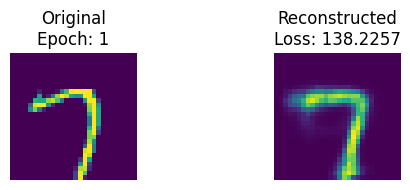

Training VAE:   5%|▌         | 1/20 [00:55<17:43, 55.95s/it]

Epoch 1/20 | Train Loss: 138.2257 | Val Loss: 109.3851


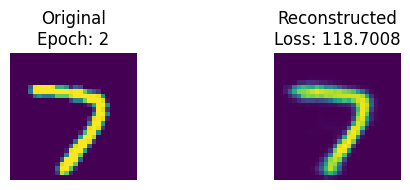

Training VAE:  10%|█         | 2/20 [01:50<16:32, 55.15s/it]

Epoch 2/20 | Train Loss: 118.7008 | Val Loss: 102.8975


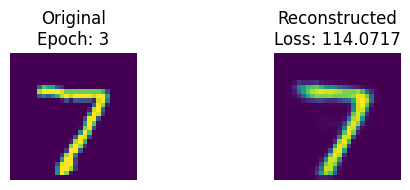

Training VAE:  15%|█▌        | 3/20 [02:44<15:31, 54.79s/it]

Epoch 3/20 | Train Loss: 114.0717 | Val Loss: 100.4249


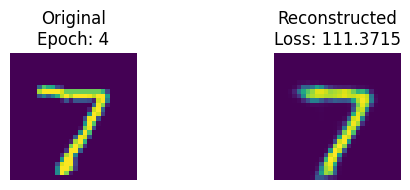

Training VAE:  20%|██        | 4/20 [03:40<14:42, 55.18s/it]

Epoch 4/20 | Train Loss: 111.3715 | Val Loss: 97.7779


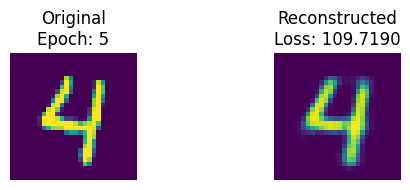

Training VAE:  25%|██▌       | 5/20 [04:34<13:43, 54.87s/it]

Epoch 5/20 | Train Loss: 109.7190 | Val Loss: 96.9351


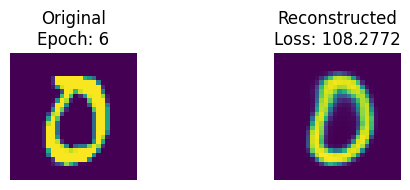

Training VAE:  30%|███       | 6/20 [05:29<12:45, 54.66s/it]

Epoch 6/20 | Train Loss: 108.2772 | Val Loss: 95.9491


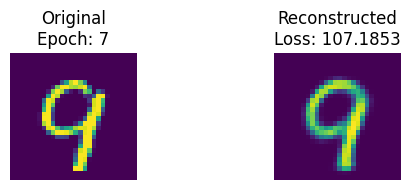

Training VAE:  35%|███▌      | 7/20 [06:24<11:52, 54.83s/it]

Epoch 7/20 | Train Loss: 107.1853 | Val Loss: 94.8975


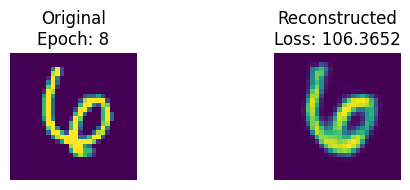

Training VAE:  40%|████      | 8/20 [07:20<11:00, 55.08s/it]

Epoch 8/20 | Train Loss: 106.3652 | Val Loss: 95.0151


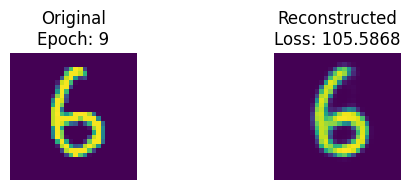

Training VAE:  45%|████▌     | 9/20 [08:15<10:07, 55.25s/it]

Epoch 9/20 | Train Loss: 105.5868 | Val Loss: 93.7607


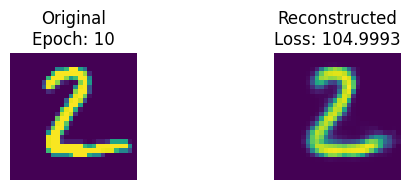

Training VAE:  50%|█████     | 10/20 [09:12<09:18, 55.83s/it]

Epoch 10/20 | Train Loss: 104.9993 | Val Loss: 93.4456


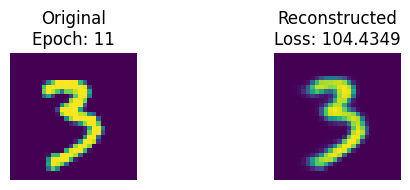

Training VAE:  55%|█████▌    | 11/20 [10:09<08:23, 55.96s/it]

Epoch 11/20 | Train Loss: 104.4349 | Val Loss: 93.2675


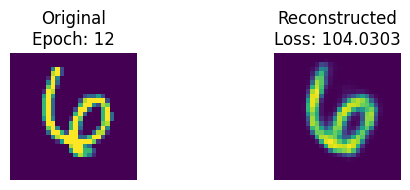

Training VAE:  60%|██████    | 12/20 [11:06<07:31, 56.40s/it]

Epoch 12/20 | Train Loss: 104.0303 | Val Loss: 92.9426


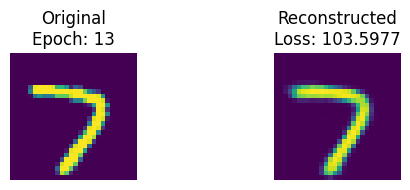

Training VAE:  65%|██████▌   | 13/20 [12:03<06:36, 56.62s/it]

Epoch 13/20 | Train Loss: 103.5977 | Val Loss: 93.4027


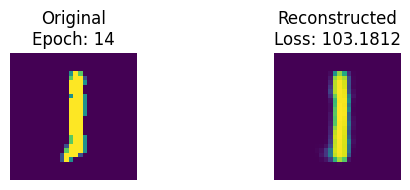

Training VAE:  70%|███████   | 14/20 [13:02<05:43, 57.18s/it]

Epoch 14/20 | Train Loss: 103.1812 | Val Loss: 92.7295


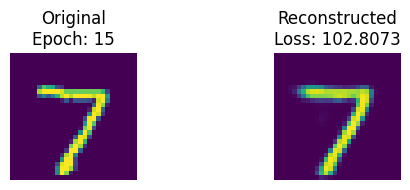

Training VAE:  75%|███████▌  | 15/20 [13:59<04:46, 57.31s/it]

Epoch 15/20 | Train Loss: 102.8073 | Val Loss: 92.2912


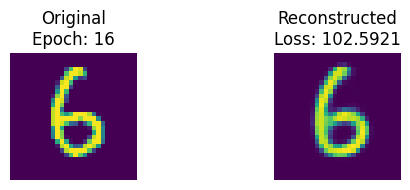

Training VAE:  80%|████████  | 16/20 [14:58<03:50, 57.73s/it]

Epoch 16/20 | Train Loss: 102.5921 | Val Loss: 92.0508


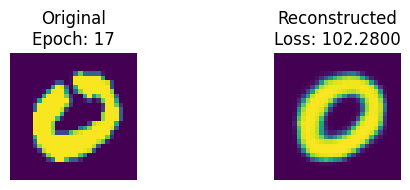

Training VAE:  85%|████████▌ | 17/20 [15:56<02:53, 57.86s/it]

Epoch 17/20 | Train Loss: 102.2800 | Val Loss: 92.1971


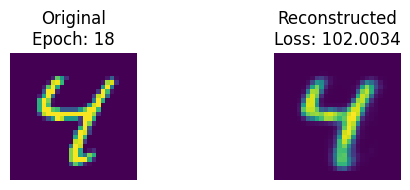

Training VAE:  90%|█████████ | 18/20 [16:55<01:56, 58.21s/it]

Epoch 18/20 | Train Loss: 102.0034 | Val Loss: 91.8745


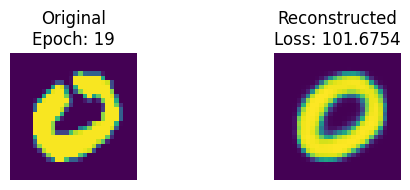

Training VAE:  95%|█████████▌| 19/20 [17:55<00:58, 58.60s/it]

Epoch 19/20 | Train Loss: 101.6754 | Val Loss: 91.5888


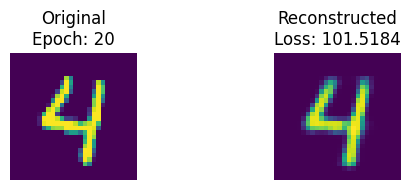

Training VAE: 100%|██████████| 20/20 [18:53<00:00, 56.68s/it]

Epoch 20/20 | Train Loss: 101.5184 | Val Loss: 91.0895


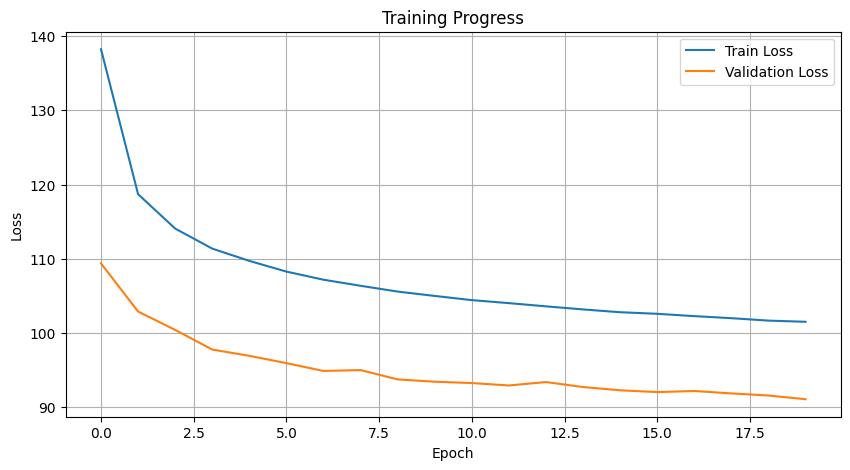

In [56]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import torch
import torch.optim as optim
from torchvision import transforms
from torch.utils.data import DataLoader

num_epochs = 20
batch_size = 32
train_losses = []
val_losses = []

for epoch in tqdm(range(num_epochs), desc='Training VAE'):
    autoencoder.train()
    train_losses_per_epoch = []

    for batch_idx, (batch, labels) in enumerate(train_loader):
        batch = batch.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        reconstruction, mu, logsigma = autoencoder(batch, labels)

        reconstruction_flat = reconstruction.view(-1, 28*28*1)
        batch_flat = batch.view(-1, 28*28*1)

        loss = criterion(batch_flat, mu, logsigma, reconstruction_flat)

        loss.backward()
        optimizer.step()

        train_losses_per_epoch.append(loss.item())

    train_loss_mean = np.mean(train_losses_per_epoch)
    train_losses.append(train_loss_mean)

    # Validation phase
    autoencoder.eval()
    val_losses_per_epoch = []

    with torch.no_grad():
        for batch_idx, (batch, labels) in enumerate(test_loader):
            batch = batch.to(device)
            labels = labels.to(device)

            reconstruction, mu, logsigma = autoencoder(batch, labels)

            reconstruction_img = reconstruction.view(-1, 28, 28, 1)

            if batch_idx == 0 and epoch % 1 == 0:
                idx = np.random.randint(0, batch.size(0))

                # Подготовка изображений
                original_img = batch[idx].permute(1, 2, 0).cpu().numpy()
                reconstructed_img = reconstruction_img[idx].cpu().numpy()

                # Визуализация
                plt.figure(figsize=(6, 2))
                plt.subplot(1, 2, 1)
                plt.imshow(original_img)
                plt.title(f"Original\nEpoch: {epoch+1}")
                plt.axis('off')

                plt.subplot(1, 2, 2)
                plt.imshow(reconstructed_img)
                plt.title(f"Reconstructed\nLoss: {train_loss_mean:.4f}")
                plt.axis('off')

                plt.tight_layout()
                plt.show()

            # Compute validation loss
            reconstruction_flat = reconstruction.view(-1, 28, 28, 1)
            batch_flat = batch.view(-1, 28*28*1)
            loss = criterion(batch_flat, mu, logsigma, reconstruction_flat)
            val_losses_per_epoch.append(loss.item())

    val_loss_mean = np.mean(val_losses_per_epoch)
    val_losses.append(val_loss_mean)

    # Вывод статистики
    print(f"Epoch {epoch+1}/{num_epochs} | Train Loss: {train_loss_mean:.4f} | Val Loss: {val_loss_mean:.4f}")

# Визуализация кривых обучения
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Progress')
plt.legend()
plt.grid()
plt.show()

### Sampling


Тут мы будем сэмплировать из CVAE. Это прикольнее, чем сэмплировать из простого AE/VAE: тут можно взять один и тот же латентный вектор и попросить CVAE восстановить из него картинки разных классов!
Для MNIST вы можете попросить CVAE восстановить из одного латентного вектора, например, картинки цифры 5 и 7.

In [63]:
z = np.array([np.random.normal(0, 1, 50) for i in range(10)])

Сгенерируем цифры 5

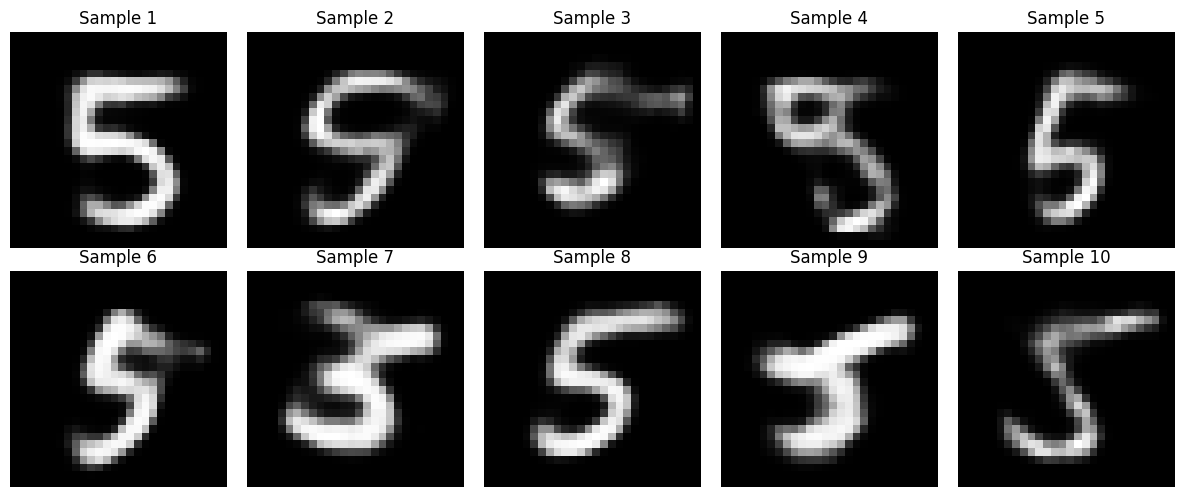

In [64]:
class_num = torch.tensor([5] * 10)
with torch.no_grad():
  output = autoencoder.sample(torch.FloatTensor(z).to(device), class_num)

fig, axes = plt.subplots(2, 5, figsize=(12, 5))
for i, ax in enumerate(axes.flat):
    img = output[i].cpu().numpy().squeeze()  # Убираем размерность канала
    ax.imshow(img, cmap='gray')
    ax.axis('off')
    ax.set_title(f'Sample {i+1}')
plt.tight_layout()
plt.show()

Цифры 7

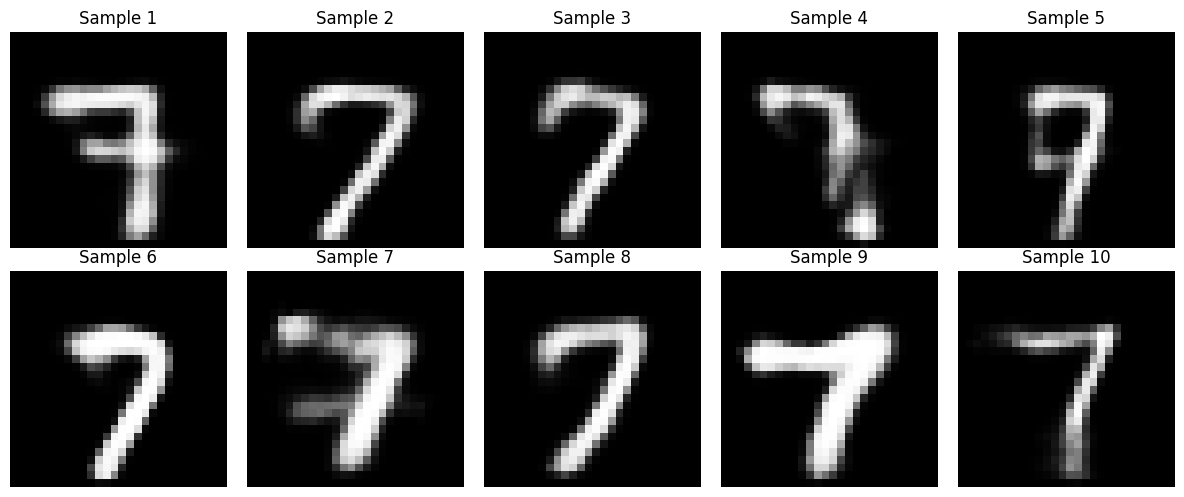

In [67]:
class_num = torch.tensor([7] * 10)
with torch.no_grad():
  output = autoencoder.sample(torch.FloatTensor(z).to(device), class_num)

fig, axes = plt.subplots(2, 5, figsize=(12, 5))
for i, ax in enumerate(axes.flat):
    img = output[i].cpu().numpy().squeeze()  # Убираем размерность канала
    ax.imshow(img, cmap='gray')
    ax.axis('off')
    ax.set_title(f'Sample {i+1}')
plt.tight_layout()
plt.show()

Splendid! Вы великолепны!


### Latent Representations

Давайте посмотрим, как выглядит латентное пространство картинок в CVAE и сравним с картинкой для VAE =)

Опять же, нужно покрасить точки в разные цвета в зависимости от класса.

In [73]:
import sklearn

In [74]:
latent_vectors = []
with torch.no_grad():
  for idx in range(10000):
        image, class_num = test_dataset[idx]

        image_tensor = image.unsqueeze(0)  # добавляем размерность батча
        class_tensor = torch.tensor([class_num])  # преобразуем число в тензор

        latent_vec = autoencoder.get_latent_vector(image_tensor, class_tensor)
        latent_vectors.append(latent_vec.cpu())

vectors = np.squeeze(np.array(latent_vectors))

vectors_embedded = sklearn.manifold.TSNE(n_components=2, learning_rate='auto', init='random', perplexity=3).fit_transform(vectors)

labels = []
for i in range(10000):
  labels.append(test_dataset[i][1])

coord_dict = {i: np.array([vec for lbl, vec in zip(labels, vectors_embedded) if lbl == i])
              for i in range(10)}

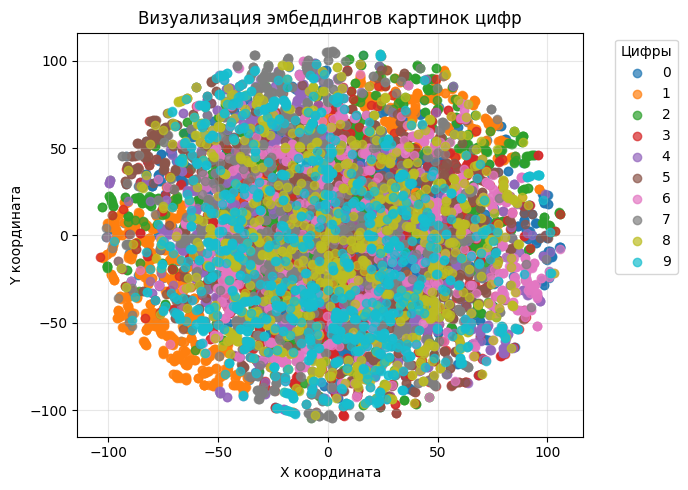

In [75]:
plt.figure(figsize=(7, 5))

colors = plt.cm.tab10(np.linspace(0, 1, 10))

for digit in range(10):
      x = coord_dict[digit][:, 0]
      y = coord_dict[digit][:, 1]
      plt.scatter(x, y, color=colors[digit], label=str(digit), alpha=0.7)

plt.title('Визуализация эмбеддингов картинок цифр')
plt.xlabel('X координата')
plt.ylabel('Y координата')
plt.legend(title='Цифры', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, alpha=0.3)
plt.tight_layout()

plt.show()

Что вы думаете насчет этой картинки? Отличается от картинки для VAE?

# BONUS 1: Denoising (2 балла)

## Внимание! За бонусы доп. баллы не ставятся, но вы можете сделать их для себя.

У автоэнкодеров, кроме сжатия и генерации изображений, есть другие практические применения. Про одно из них эта бонусная часть задания.

Автоэнкодеры могут быть использованы для избавления от шума на фотографиях (denoising). Для этого их нужно обучить специальным образом: input картинка будет зашумленной, а выдавать автоэнкодер должен будет картинку без шума.
То есть, loss-функция AE останется той же (MSE между реальной картинкой и выданной), а на вход автоэнкодеру будет подаваться зашумленная картинка.

<a href="https://ibb.co/YbRJ1nZ"><img src="https://i.ibb.co/0QD164t/Screen-Shot-2020-06-04-at-4-49-50-PM.png" alt="Screen-Shot-2020-06-04-at-4-49-50-PM" border="0"></a>

Для этого нужно взять ваш любимый датасет (датасет лиц из первой части этого задания или любой другой) и сделать копию этого датасета с шумом.

В питоне шум можно добавить так:

In [76]:
noise_factor = 0.5
X_noisy = X + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=X.shape)

NameError: name 'X' is not defined

In [ ]:
<тут ваш код обучения автоэнкодера на зашумленных картинках. Не забудьте разбить на train/test!>

In [ ]:
<тут проверка, как AE убирает шум с тестовых картинок. Надеюсь, все получилось =)>

# BONUS 2: Image Retrieval (2 балла)

## Внимание! За бонусы доп. баллы не ставятся, но вы можете сделать их для себя.

Давайте представим, что весь наш тренировочный датасет -- это большая база данных людей. И вот мы получили картинку лица какого-то человека с уличной камеры наблюдения (у нас это картинка из тестового датасета) и хотим понять, что это за человек. Что нам делать? Правильно -- берем наш VAE, кодируем картинку в латентное представление и ищем среди латентных представлений лиц нашей базы самые ближайшие!

План:

1. Получаем латентные представления всех лиц тренировочного датасета
2. Обучаем на них LSHForest `(sklearn.neighbors.LSHForest)`, например, с `n_estimators=50`
3. Берем картинку из тестового датасета, с помощью VAE получаем ее латентный вектор
4. Ищем с помощью обученного LSHForest ближайшие из латентных представлений тренировочной базы
5. Находим лица тренировочного датасета, которым соответствуют ближайшие латентные представления, визуализируем!

Немного кода вам в помощь: (feel free to delete everything and write your own)

In [ ]:
codes = <поучите латентные представления картинок из трейна>

In [ ]:
# обучаем LSHForest
from sklearn.neighbors import LSHForest
lshf = LSHForest(n_estimators=50).fit(codes)

In [ ]:
def get_similar(image, n_neighbors=5):
  # функция, которая берет тестовый image и с помощью метода kneighbours у LSHForest ищет ближайшие векторы
  # прогоняет векторы через декодер и получает картинки ближайших людей

  code = <получение латентного представления image>

  (distances,),(idx,) = lshf.kneighbors(code, n_neighbors=n_neighbors)

  return distances, X_train[idx]

In [ ]:
def show_similar(image):

  # функция, которая принимает тестовый image, ищет ближайшие к нему и визуализирует результат

    distances,neighbors = get_similar(image,n_neighbors=11)

    plt.figure(figsize=[8,6])
    plt.subplot(3,4,1)
    plt.imshow(image.cpu().numpy().transpose([1,2,0]))
    plt.title("Original image")

    for i in range(11):
        plt.subplot(3,4,i+2)
        plt.imshow(neighbors[i].cpu().numpy().transpose([1,2,0]))
        plt.title("Dist=%.3f"%distances[i])
    plt.show()

In [ ]:
<тут выведите самые похожие лица к какому-нибудь лицу из тестовой части датасета>